# import packages

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize as opti
from scipy.special import comb, perm
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 40

%matplotlib inline

# define the core function who calculates the probability of every grid

In [2]:
def f(N, M, q):
    assert N > M
    P = np.full((M + 1, N - M + 1), np.nan)
    P[M, N - M] = 1
    i = M - 1
    j = N - M
    while True:
        if i >= 0 and i <= M and j >= 0 and j <= N-M:
            P[i, j] = (P[i + 1, j] if i + 1 <= M else 0) * (i + 1) * q / ((i + 1) * q + j) + (P[i, j + 1] if j + 1 <= N - M and i != 0 else 0) * (j + 1) / (i * q + (j + 1))
        if i == 0 and j == 0:
            break
        if j - 1 < 0 :
            i = i + j - 1 - (N - M)
            j = N - M
        else:
            i = i + 1
            j = j - 1
    return P

# demo, N = 10, M = 3

In [3]:
N = 10
M = 3
q = 2
P = f(N, M, q)
assert np.abs(P[0].sum() - 1) < 1e-6

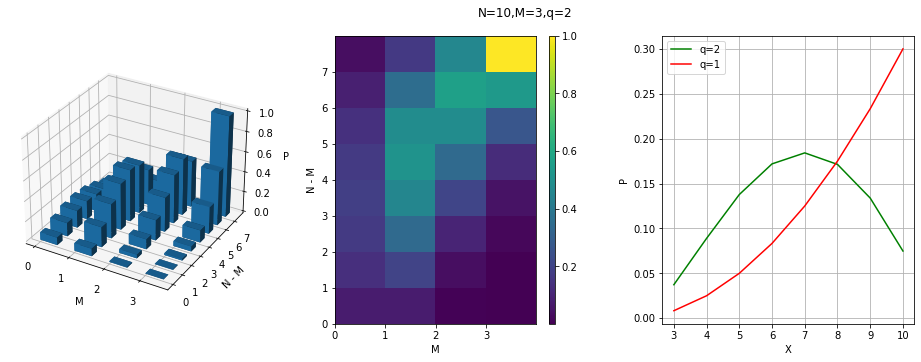

In [4]:
xpos, ypos = np.meshgrid(np.arange(M + 1), np.arange(N - M + 1), indexing='ij')
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = P.ravel()

plt.close()
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3, figure=fig, left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.3, hspace=0.35)
ax0 = fig.add_subplot(gs[0, 0], projection='3d')
ax0.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax0.set_xticks(np.arange(M + 1))
ax0.set_yticks(np.arange(N - M + 1))
ax0.set_xlabel('M')
ax0.set_ylabel('N - M')
ax0.set_zlabel('P')
ax1 = fig.add_subplot(gs[0, 1])
im = ax1.pcolormesh(np.arange(M + 2), np.arange(N - M + 2), P.T)
ax1.set_xticks(np.arange(M + 1))
ax1.set_yticks(np.arange(N - M + 1))
ax1.set_xlabel('M')
ax1.set_ylabel('N - M')
fig.colorbar(im, ax=ax1, aspect=50)
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(np.arange(M, N + 1), P[0][::-1], color='g', label=f'q={q}')
ax2.set_xticks(np.arange(M, N + 1))
ax2.plot(np.arange(M, N + 1), comb(np.arange(M - 1, N), M - 1) / comb(N, M), color='r', label='q=1')
ax2.set_xlabel('X')
ax2.set_ylabel('P')
ax2.legend()
ax2.grid()
fig.suptitle('N={},M={},q={}'.format(N, M, q))
plt.savefig('nmq.png')

# input real parameters

In [5]:
N = 956
M = 180

# define function who calculates average of X and standard deviation of X

In [6]:
def aver(q):
    P = f(N, M, q)
    l = (np.arange(M, N + 1) * P[0][::-1]).sum()
    return l

In [7]:
def std(q):
    P = f(N, M, 12.9)
    l = (np.arange(M, N + 1) * P[0][::-1]).sum()
    return np.sqrt((np.power(np.arange(M, N + 1) - l, 2) * P[0][::-1]).sum())

# numerically calculate q (find root)

In [8]:
L_r = lambda q : (aver(q) - 457.584)
start = time.time()
q_rec = opti.root_scalar(L_r, bracket=[1.0, 100])
end = time.time()
print('solving equation consumes {}s'.format(end - start))
print('q={}, resi={}'.format(q_rec.root, L_r(q_rec.root)))
print('average={}, standard deviation={}'.format(aver(q_rec.root), std(q_rec.root)))

solving equation consumes 7.61344051361084s
q=12.901458442142584, resi=-6.821210263296962e-13
average=457.5839999999993, standard deviation=48.82877442472194


# given q, show the percentile of X

In [9]:
P = f(N, M, q_rec.root)
ft = interp1d(np.arange(M, N + 1), P[0][::-1].cumsum())

90% percentile of X for given q is 521.9199333106926


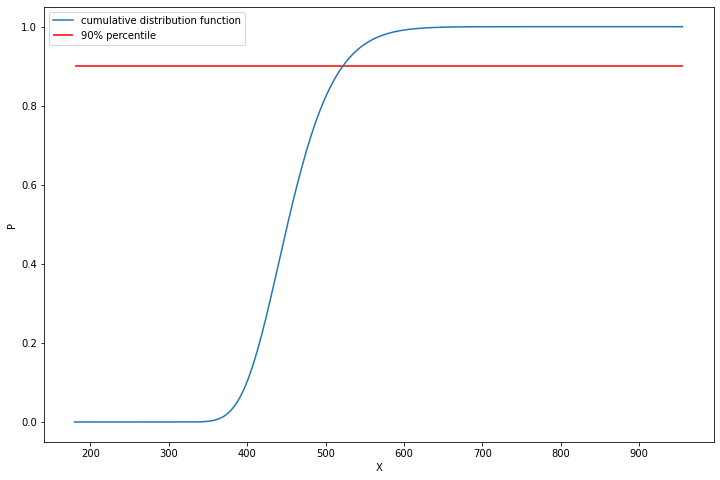

In [10]:
n = 0.9
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(np.arange(180, 956), ft(np.arange(180, 956)), label='cumulative distribution function')
ax.hlines(n, xmin=180, xmax=956, color='r', label='90% percentile')
ax.set_xlabel('X')
ax.set_ylabel('P')
ax.legend()
plt.savefig('a.png')
x_r = opti.root_scalar(lambda x : (ft(x) - n), bracket=[180, 956])
print('90% percentile of X for given q is {}'.format(x_r.root))